# Import Libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf

import random as python_random
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

import warnings
warnings.filterwarnings("ignore")

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

from keras.layers.core import  Dropout

from keras.layers import Flatten

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D

from keras.layers import GRU
from keras.layers import RNN

Load Data
Convert to timestamp format

In [2]:
data=pd.read_csv(r"test.csv")
data.isnull().sum(axis = 0)
format_date='%m/%d/%y %H:%M'
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format=format_date)
data=data.set_index('Timestamp')
data.head()

,Value,Weather
Timestamp,,
2015-01-01 00:00:00,27688.83525,20.0
2015-01-01 01:00:00,30405.22056,19.0
2015-01-01 02:00:00,30180.64483,19.0
2015-01-01 03:00:00,29685.09342,17.0
2015-01-01 04:00:00,30334.16236,17.0


Text(0, 0.5, 'Power Consumption')

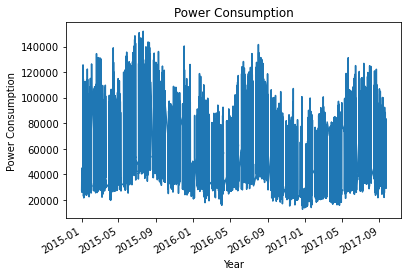

In [3]:
data["Value"].plot()

plt.title("Power Consumption")
plt.xlabel("Year")
plt.ylabel("Power Consumption")

In [4]:
data.shape

(20065, 2)

# Autocorrolation

Power

Determine LAG for LSTM and how to fill in missing data

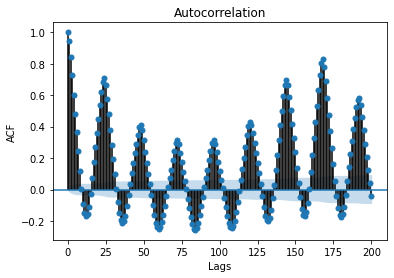

In [5]:
energy_array=data["Value"].values
energy_array = energy_array[~np.isnan(energy_array)]

plot_acf(energy_array,lags=200)
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.show()

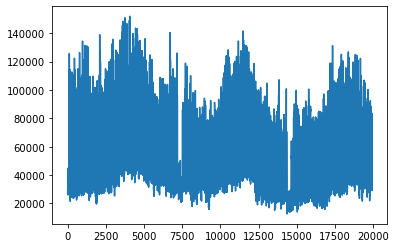

In [6]:
plt.plot(energy_array)

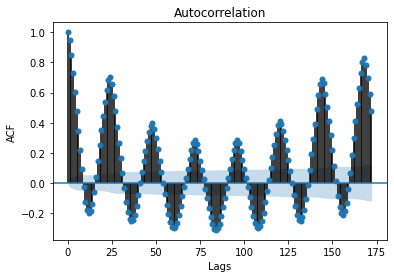

In [7]:
plot_acf(energy_array[0:10000],lags=172)
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.show()

Data is provided in hour interval. According to the autocorrolation plots, the power is the same every 168 lags which is 7
days. This corresponds to energy usage pattens

Weather

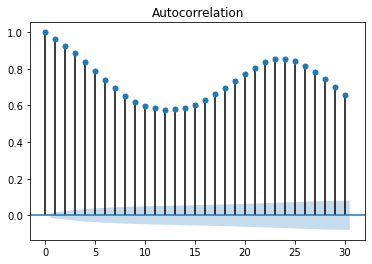

In [8]:
weather_array=data["Weather"].values
weather_array= weather_array[~np.isnan(weather_array)]

plot_acf(weather_array,lags=30)
plt.show()

There is a strong corrolation with weather 24 hours (1 Day) apart

# Fill in missing data

In [9]:
def fill_nan(df,col,lag):
    
    count=0
    for i in range(df.shape[0]):
        if  np.isnan(df.iloc[i,col])==True:
            if np.isnan(df.iloc[i+lag,col])==False:
                df.iloc[i,col]=df.iloc[i+lag,col]
            else:
                if np.isnan(df.iloc[i-lag,col])==False:
                    df.iloc[i,col]=df.iloc[i-lag,col]
                else:
                    print("Have a look")        
    return df


Missing power data is filled in with data 168 steps ahead where avaliable, if not avaliable it is filled with
data from the168 steps back

Weather is filled with lag of 2 hours

In [10]:
data=fill_nan(data,0,168)
data=fill_nan(data,1,24)
data.isnull().sum(axis = 0)

Value      0
Weather    0
dtype: int64

# Analysis of Data (EDA)

Extract the year, date, time and day of week info. from dataset if order to do filtering 

In [11]:
data=data.reset_index()
data['Year'] = pd.DatetimeIndex(data['Timestamp']).year
data['Month'] = pd.DatetimeIndex(data['Timestamp']).month

data['DOW'] = pd.DatetimeIndex(data['Timestamp']).dayofweek
data["Time"]=pd.DatetimeIndex(data['Timestamp']).time
data.head()

,Timestamp,Value,Weather,Year,Month,DOW,Time
0,2015-01-01 00:00:00,27688.83525,20.0,2015,1,3,00:00:00
1,2015-01-01 01:00:00,30405.22056,19.0,2015,1,3,01:00:00
2,2015-01-01 02:00:00,30180.64483,19.0,2015,1,3,02:00:00
3,2015-01-01 03:00:00,29685.09342,17.0,2015,1,3,03:00:00
4,2015-01-01 04:00:00,30334.16236,17.0,2015,1,3,04:00:00


Mean power plot over the years

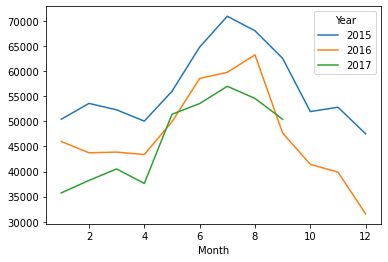

In [12]:
tbl_power_mean=pd.pivot_table(data,values="Value",index="Month", columns='Year',aggfunc={"Value":np.mean})
tbl_power_mean.plot()

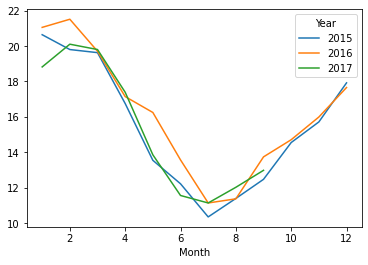

In [13]:
tbl_weather_mean=pd.pivot_table(data,values="Weather",index="Month", columns='Year',aggfunc={"Weather":np.mean})
tbl_weather_mean.plot()

From the plots above, it can be seend that as Temp. decreases, power consumption increases

Time of day plot

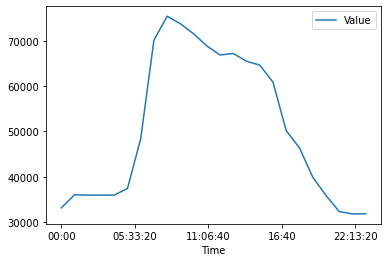

In [14]:
tbl_TOD_mean_tod=pd.pivot_table(data,values="Value",index="Time",aggfunc={"Value":np.mean})
tbl_TOD_mean_tod.plot()

Weather VS Power overlaid

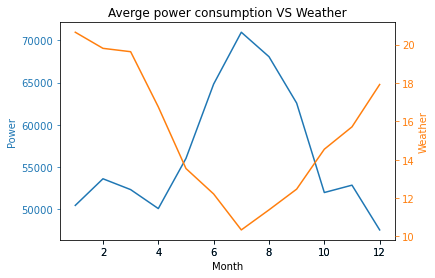

In [15]:
x1=tbl_power_mean.iloc[:,0].values
x2=tbl_weather_mean.iloc[:,0]
y=np.arange(1,13)

fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax2=fig.add_subplot(111, label="2", frame_on=False)


ax.plot(y, x1, color="C0")
ax.set_xlabel("Month", color="black")
ax.set_ylabel("Power", color="C0")
ax.tick_params(axis='x', colors="C0")
ax.tick_params(axis='y', colors="C0")

ax2.plot(y, x2, color="C1")
ax2.yaxis.tick_right()
ax2.set_ylabel('Weather', color="C1")       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="black")
ax2.tick_params(axis='y', colors="C1")

plt.title("Averge power consumption VS Weather")

plt.show()


(Text(0.5, 1.0, 'Mean Weather'),
 <matplotlib.axes._subplots.AxesSubplot at 0x213b0d48370>)

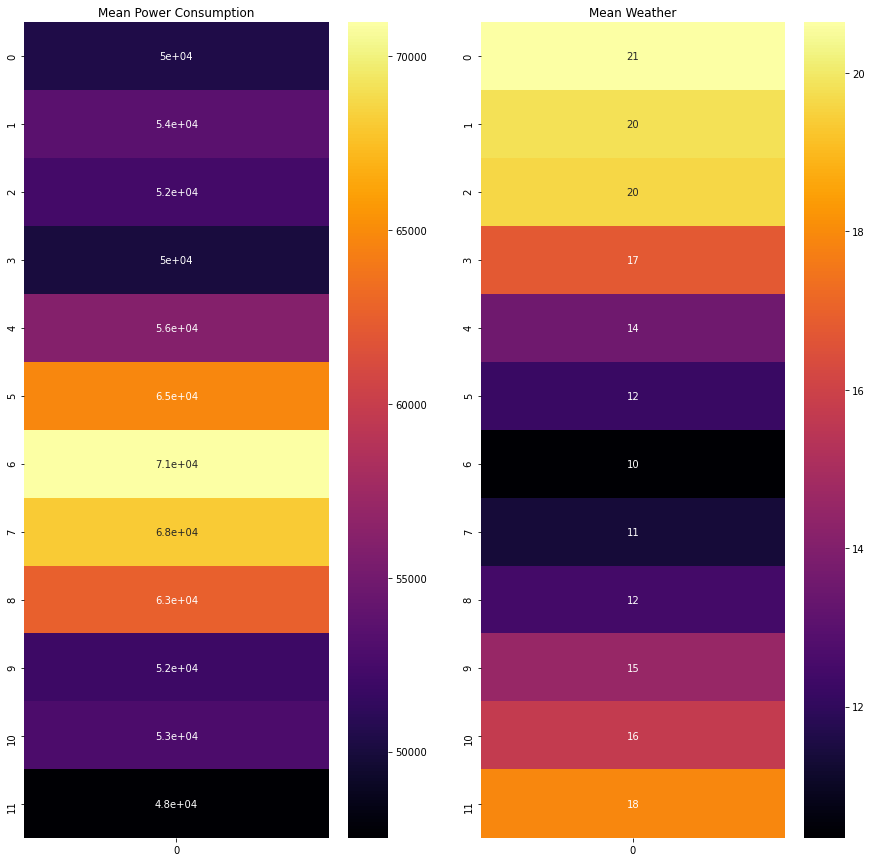

In [16]:
plt.figure(figsize=(15,15))   
plt.subplot(1,2, 1).set_title("Mean Power Consumption"),sns.heatmap(x1[:,np.newaxis], annot=True,cmap="inferno")
plt.subplot(1,2, 2).set_title("Mean Weather"),sns.heatmap(x2[:,np.newaxis], annot=True,cmap='inferno')

Confirming no missing values

In [17]:
data.shape[0]/24
data.isnull().sum(axis = 0)

Timestamp    0
Value        0
Weather      0
Year         0
Month        0
DOW          0
Time         0
dtype: int64

# Models

Create a Vanilla LSTM to use as a baseline

In [18]:
#resample
data_i=data.set_index('Timestamp')
data_resample= data_i.resample('D').agg({'Value': np.sum, 'Weather': np.mean})
data_resample=data_resample.dropna()
data_array=data_resample.values

In [19]:
# def normalize(data, train_split,days):
#     data_mean = data[:train_split*days].mean(axis=0)
#     data_std = data[:train_split*days].std(axis=0)
#     return (data - data_mean) / data_std

def create_lag(data,lag):    
    x,y=[],[]    
    if len(data) - lag <= 0: #means dataset is smaller than lag
        x.append(data)       
    else:       
        for i in range(len(data)-lag):
            y.append(data[i+lag])
            x.append(data[i:i+lag])
            
        x,y=np.array(x),np.array(y)         
        x=np.reshape(x,(x.shape[0],x.shape[1],1)) #change one for more features ,#reshape x to [timestep,samples,features]    
    return x,y

def create_split(x,y,days):
    
    x_train=x[0:-365*days]
    y_train=y[0:-365*days]
    
    x_test=x[-365*days:]
    y_test=y[-365*days:]
    
    return x_train,y_train,x_test,y_test

Resample the data to daily power consumption as large variance is not expected throughout the day

In [20]:
def create_lag_m(data,lag):    
    x,y=[],[]    
    if len(data) - lag <= 0: #means dataset is smaller than lag
        x.append(data)       
    else:       
        for i in range(len(data)-lag):
            y.append(data[i+lag,0])
            x.append(data[i:i+lag])
            
        x,y=np.array(x),np.array(y)      
#         #reshape x to [timestep,samples,features]       
        x=np.reshape(x,(x.shape[0],x.shape[1],2)) #change one for more features 
    return x,y

Vanilla LSTM - Single Varibale

In [21]:
def model1(LSTM_layer_depth,lag,validation,data_,batch_size,epochs):
    
    '''Vanilla LSTM, univar'''
    
    x,y=create_lag(data_[:,0],lag)
    x_train,y_train,x_test,y_test=create_split(x,y,days)
    
    verbose=0
    model=Sequential()
    model.add(LSTM(LSTM_layer_depth, activation='relu', input_shape=(lag, 1))) #change for features
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    keras_dict = {
        'x': x_train,
        'y': y_train,
        'batch_size': batch_size,
        'epochs': epochs,
        'shuffle': False,
        'verbose':0
    }

    if validation==True:
        keras_dict.update({
            'validation_data': (x_test, y_test)
        })

    history=model.fit(
        **keras_dict
    )
    
    #Predict using walk fwd validation 
    y_p=model.predict(x_test) 
    
    test=x_train[-1:]
    
    y_pnew=[]
    for i in range(len(y_p)):
        #print(test)
        test_predict=model.predict(test) 
        test_predict=test_predict.flatten()[-1]
        #print(test_predict)
        y_pnew.append(test_predict)
#         print(len(y_pnew))
#         print(test.shape)
#         print(y_pnew[-1])      
        test_new=np.hstack((np.delete(test,0),y_pnew[-1]))
        #print(test_new)
        
        
        test=np.reshape(test_new,(1,x_test.shape[1],1))
        #print(test.shape)
        #print("")
        

        

    model=model

    return model,history,y_p,y_test,y_pnew

In [22]:
def model_1_GRU(LSTM_layer_depth,lag,validation,data_,batch_size,epochs):
    
    '''Vanilla GRU, univar'''
    
    x,y=create_lag(data_[:,0],lag)
    x_train,y_train,x_test,y_test=create_split(x,y,days)
    
    verbose=0
    model=Sequential()
    model.add(GRU(LSTM_layer_depth, activation='relu', input_shape=(lag, 1))) #change for features
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    keras_dict = {
        'x': x_train,
        'y': y_train,
        'batch_size': batch_size,
        'epochs': epochs,
        'shuffle': False,
        'verbose':0
    }

    if validation==True:
        keras_dict.update({
            'validation_data': (x_test, y_test)
        })

    history=model.fit(
        **keras_dict
    )
    
    #Predict using walk fwd validation 
    y_p=model.predict(x_test) 
    
    test=x_train[-1:]
    
    y_pnew=[]
    for i in range(len(y_p)):
        test_predict=model.predict(test) 
        test_predict=test_predict.flatten()[-1]
        y_pnew.append(test_predict)  
        test_new=np.hstack((np.delete(test,0),y_pnew[-1]))
        test=np.reshape(test_new,(1,x_test.shape[1],1))
    model=model

    return model,history,y_p,y_test

Vanilla GRU - Multivariate

In [23]:
def model2(LSTM_layer_depth,lag,validation,data_new,batch_size,epochs):
    ''' GRU, multivar'''
    
    x,y=create_lag_m(data_new,lag)
    x_train,y_train,x_test,y_test=create_split(x,y,days)
    
    model=Sequential()
    model.add(GRU(LSTM_layer_depth, activation='relu' , input_shape=(lag, 2)))#cahnge for features
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    keras_dict = {
        'x': x_train,
        'y': y_train,
        'batch_size': batch_size,
        'epochs': epochs,
        "verbose":0,
        'shuffle': False
    }

    if validation==True:
        keras_dict.update({
            'validation_data': (x_test, y_test)
        })

    history=model.fit(
        **keras_dict
    )
    
    y_p=model.predict(x_test) 

    model=model

    return model,history,y_p,y_test

In [25]:
def model6(LSTM_layer_depth,lag,validation,data_new,batch_size,epochs):
    ''' LSTM, multivar'''
    
    x,y=create_lag_m(data_new,lag)
    x_train,y_train,x_test,y_test=create_split(x,y,days)
    
    model=Sequential()
    model.add(LSTM(LSTM_layer_depth, activation='relu' , input_shape=(lag, 2)))#cahnge for features
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    keras_dict = {
        'x': x_train,
        'y': y_train,
        'batch_size': batch_size,
        'epochs': epochs,
        "verbose":0,
        'shuffle': False
    }

    if validation==True:
        keras_dict.update({
            'validation_data': (x_test, y_test)
        })

    history=model.fit(
        **keras_dict
    )
    
    y_p=model.predict(x_test) 

    model=model

    return model,history,y_p,y_test

In [26]:
def model7(LSTM_layer_depth,lag,validation,data_new,batch_size,epochs):
    #print("GRU,Droput added")
    
    '''Try with dropout'''
    LSTM_layer_depth=10
    x,y=create_lag_m(data_new,lag)
    x_train,y_train,x_test,y_test=create_split(x,y,days)
    
    model=Sequential()
    model.add(GRU(LSTM_layer_depth,  return_sequences=True,activation='relu' , input_shape=(lag, 2)))
    model.add(Dropout(0.2))#cahnge for features
    model.add(GRU(10, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    keras_dict = {
        'x': x_train,
        'y': y_train,
        'batch_size': batch_size,
        'epochs': epochs,
        "verbose":0,
        'shuffle': False
    }

    if validation==True:
        keras_dict.update({
            'validation_data': (x_test, y_test)
        })

    history=model.fit(
        **keras_dict
    )
    
    y_p=model.predict(x_test) 

    model=model

    return model,history,y_p,y_test

In [27]:
train_split=365
days=1
data_=data_array #normalize(data_array, train_split,days)

x_new=[]
y_new=[]
for i in range(data_.shape[0]-1):
    x_new.append(data_[i,0])
    y_new.append(data_[i+1,1])
    

x_new,y_new=np.array(x_new),np.array(y_new)     

data_new=np.transpose(np.vstack((x_new,y_new)))


In [28]:
def model_main_repeat(episodes,data,model_choice=1) : 
    y_p_epi=[]
    loss=[]
    val_loss=[]
    
    y_p_epi_new=[]
    
    for i in range(episodes):  
        print("Episode:", i)
        
        if model_choice==1:
            model,history,y_p,y_test,y_pnew=model1(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
        
        if model_choice==2:
            model,history,y_p,y_test=model2(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
            
#         if model_choice==3:
#             model,history,y_p,y_test=model1_ADD(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
            
#         if model_choice==4:
#             model,history,y_p,y_test=model4(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
       
#         if model_choice==5:
#             model,history,y_p,y_test=model5(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
            
        if model_choice==6:
            model,history,y_p,y_test=model6(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
#         if model_choice==7:
#             model,history,y_p,y_test=model7(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
            
#         if model_choice==8:
#             model,history,y_p,y_test=model8(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
        
        if model_choice==9:
            model,history,y_p,y_test=model_1_GRU(LSTM_layer_depth,lag,validation,data,batch_size,epochs)
            
#         if model_choice==10:
#             model,history,y_p,y_test=model1_ADD(LSTM_layer_depth,lag,validation,data,batch_size,epochs)

                 
        y_p_epi.append(y_p)
#         y_p_epi_new.append(y_pnew)
        
        
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        
    
    yp=np.mean(np.array(y_p_epi),axis=0) 
    ypnew=np.mean(np.array(y_p_epi_new),axis=0) 
    
    loss=np.mean(np.array(loss),axis=0)  
    val_loss=np.mean(np.array(val_loss),axis=0)  
    
    
    yp=yp.flatten()
    ypnew=1
    #ypnew=ypnew.flatten()
   
    y_test=y_test.flatten()
    
    plt.figure(figsize=(20,20))   
    
    rows=3
    cols=1
    plt.subplot(rows,cols, 1).set_title("Loss"),plt.plot(history.history['loss'],color="r",label='Loss')
    plt.subplot(rows,cols, 1).set_title("Loss"),plt.plot(history.history['val_loss'],color="b",label='Validation loss'),plt.xlabel("Epochs"),plt.ylabel("Loss")
    plt.legend()
    plt.subplot(rows,cols, 2).set_title("Predict VS Test"),plt.plot(y_test,color='C1',label='Actual'),plt.xlabel("Day"),plt.ylabel("Power Consumption")
    plt.subplot(rows,cols, 2).set_title("Predict VS Test"),plt.plot(yp,color='C2',label='Predict')
    

    plt.legend()
    
    error=[]
    mae=[]
    rmse=[]

    for j in range(len(yp)):
        error.append(abs(yp[j]-y_test[j])/(abs(y_test[j])))
        mae.append(abs(yp[j]-y_test[j]))

        rmse.append((y_test[j]-yp[j])**2)

    plt.subplot(rows,cols, 3).set_title("Error"),plt.plot(np.array(error).flatten()),plt.xlabel("Day"),plt.ylabel("Error")
    print("")
    print("Short term forecasting")
    print("===========================================================")
    
    n=7
    print("MAPE STF",np.sum(error[0:n])/len(error[0:n]))
    print("MAE STF",np.sum(mae[0:n])/len(error[0:n]))
    print("RMSE STF",np.sqrt(np.sum(rmse[0:n])/len(error[0:n])))
    
    print("")
    
    print("Medium term forcasting")
    print("===========================================================")
    n=30
    print("MAPE MTF",np.sum(error[0:n])/len(error[0:n]))
    print("MAE MTF",np.sum(mae[0:n])/len(error[0:n]))
    print("RMSE MTF",np.sqrt(np.sum(rmse[0:n])/len(error[0:n])))
    
    print("")
    
    print("Long term forecasting")
    print("===========================================================")
    print("MAPE LTF",np.sum(error)/y_test.shape[0])
    print("MAE LTF",np.sum(mae)/y_test.shape[0])
    print("RMSE LTF",np.sqrt(np.sum(rmse)/y_test.shape[0]))

        
    return y_p_epi,y_test,error,ypnew

In [29]:
lag=7*days #Need to factor in days now
LSTM_layer_depth=20
validation=True
batch_size=7*days
epochs=50
LSTM_layer_depth=20
episodes=10
#y_p_epi,y_test,error=model_main_repeat(episodes,data_,model_choice=1)

# Single Variable

Vanilla LSTM

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9

Short term forecasting
MAPE STF 0.07146983829386015
MAE STF 112881.57208857147
RMSE STF 137136.3613892018

Medium term forcasting
MAPE MTF 0.09014129692305448
MAE MTF 124104.60562933332
RMSE MTF 143518.51739064723

Long term forecasting
MAPE LTF 0.4660754474763788
MAE LTF 165791.97127254793
RMSE LTF 234728.59552507225


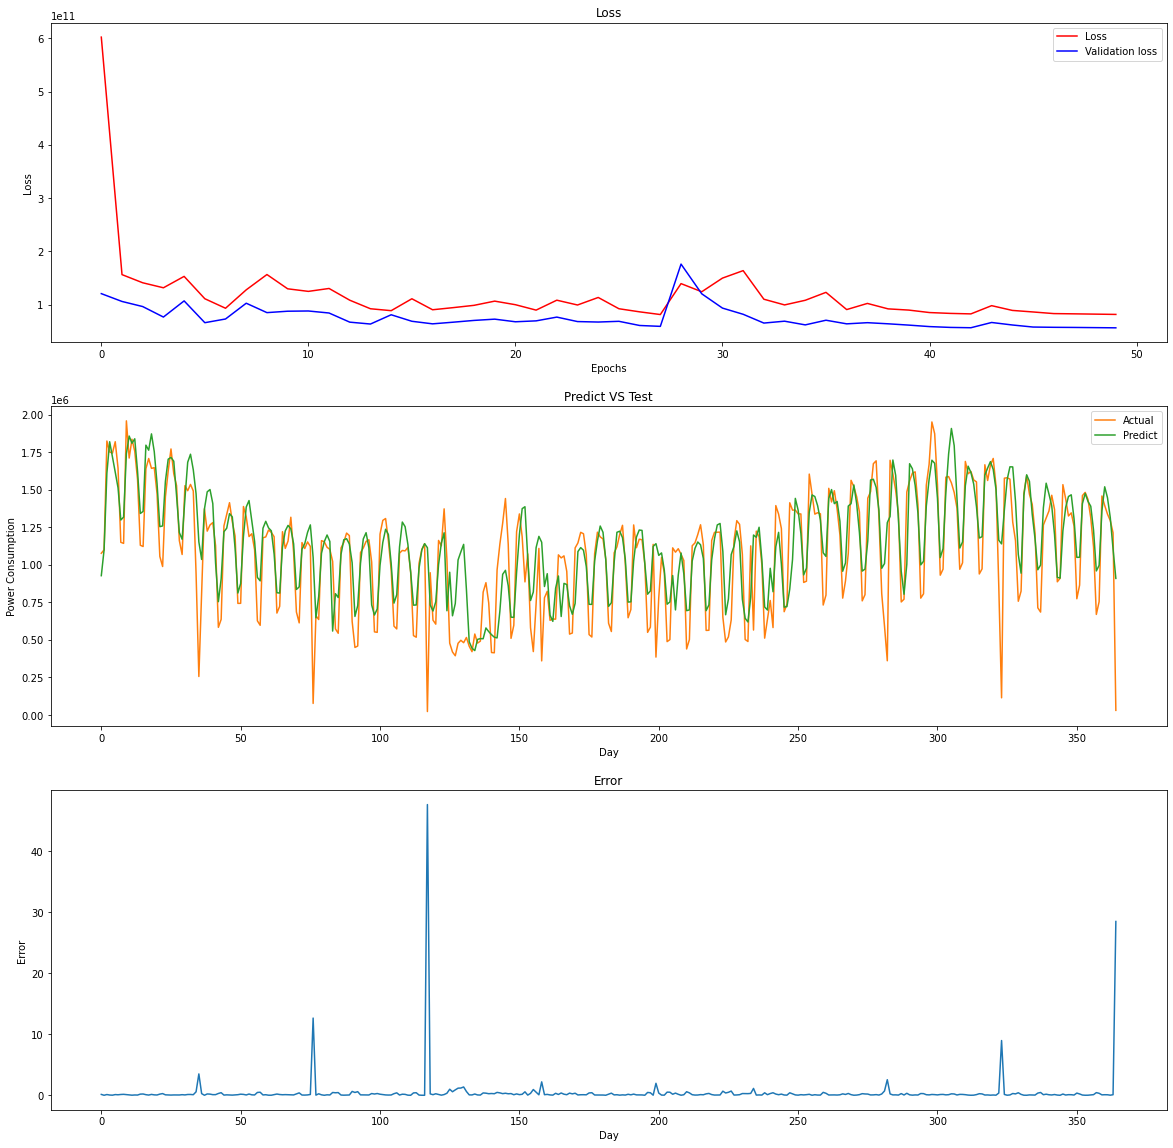

In [30]:
epochs=50
LSTM_layer_depth=100

y_p_epi1,y_test1,error1,y_pnew1=model_main_repeat(episodes,data_,model_choice=1)

Vanilla GRU

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9

Short term forecasting
MAPE STF 0.06920648494108354
MAE STF 113128.17078285721
RMSE STF 142483.60835495824

Medium term forcasting
MAPE MTF 0.07244037999564826
MAE MTF 107253.72664066663
RMSE MTF 128391.43488673914

Long term forecasting
MAPE LTF 0.3635613567578488
MAE LTF 149594.86662342466
RMSE LTF 215571.6722849918


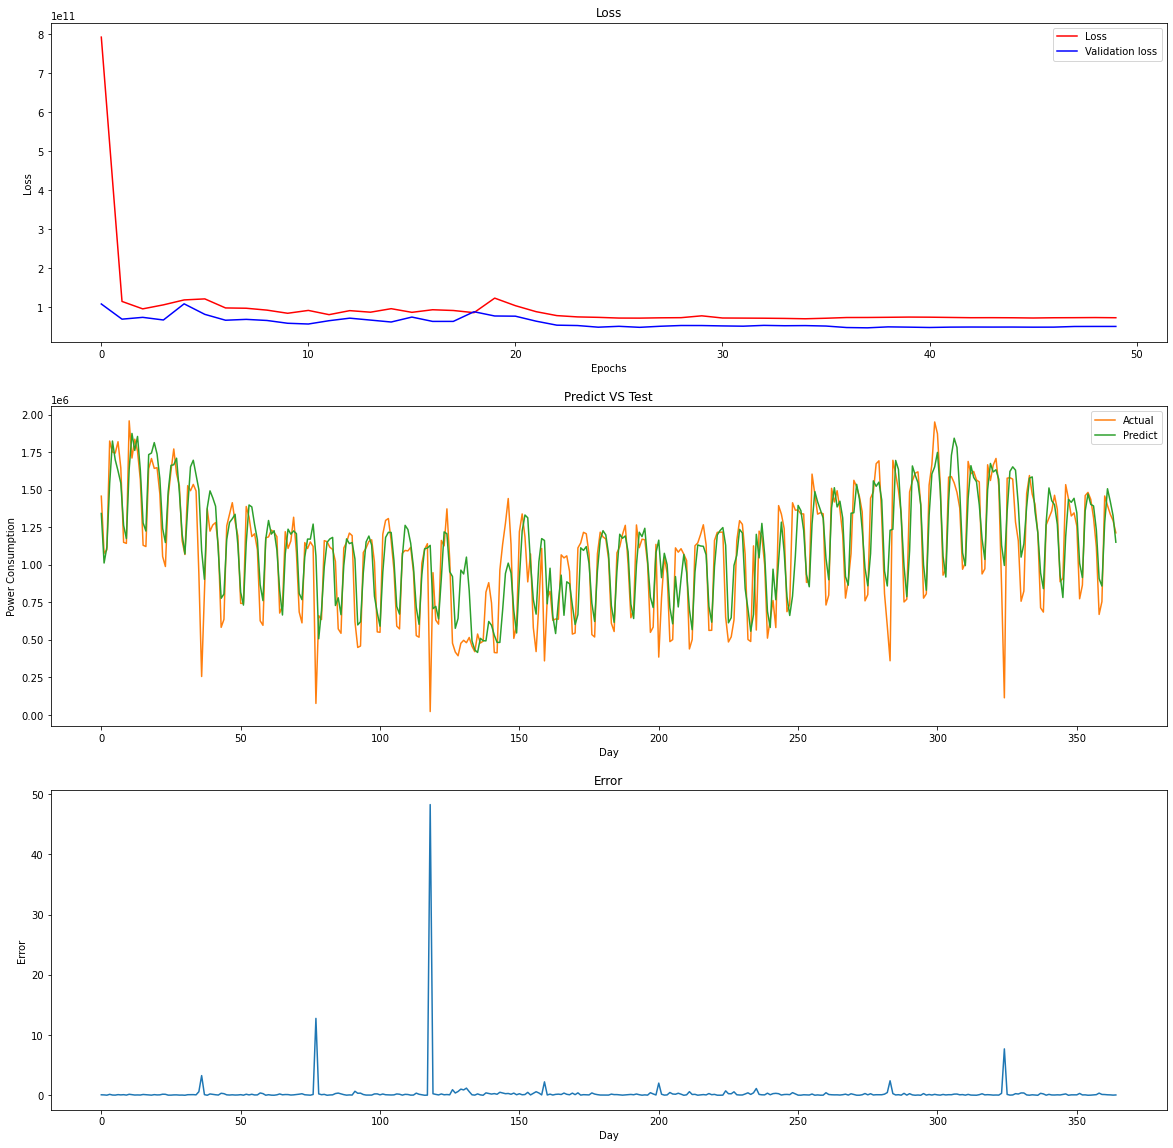

In [31]:
epochs=50
LSTM_layer_depth=100

y_p_epi22,y_test22,error22,y_pnew22=model_main_repeat(episodes,data_new,model_choice=9)

# Multivariate models

Vanilla GRU - Multivariate

dataset1

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9

Short term forecasting
MAPE STF 0.06691837607007688
MAE STF 113411.8376
RMSE STF 140307.69808268716

Medium term forcasting
MAPE MTF 0.07266009990958616
MAE MTF 109336.48392666662
RMSE MTF 130222.23611710509

Long term forecasting
MAPE LTF 0.44648222169941076
MAE LTF 154278.34707758905
RMSE LTF 222439.49722703957


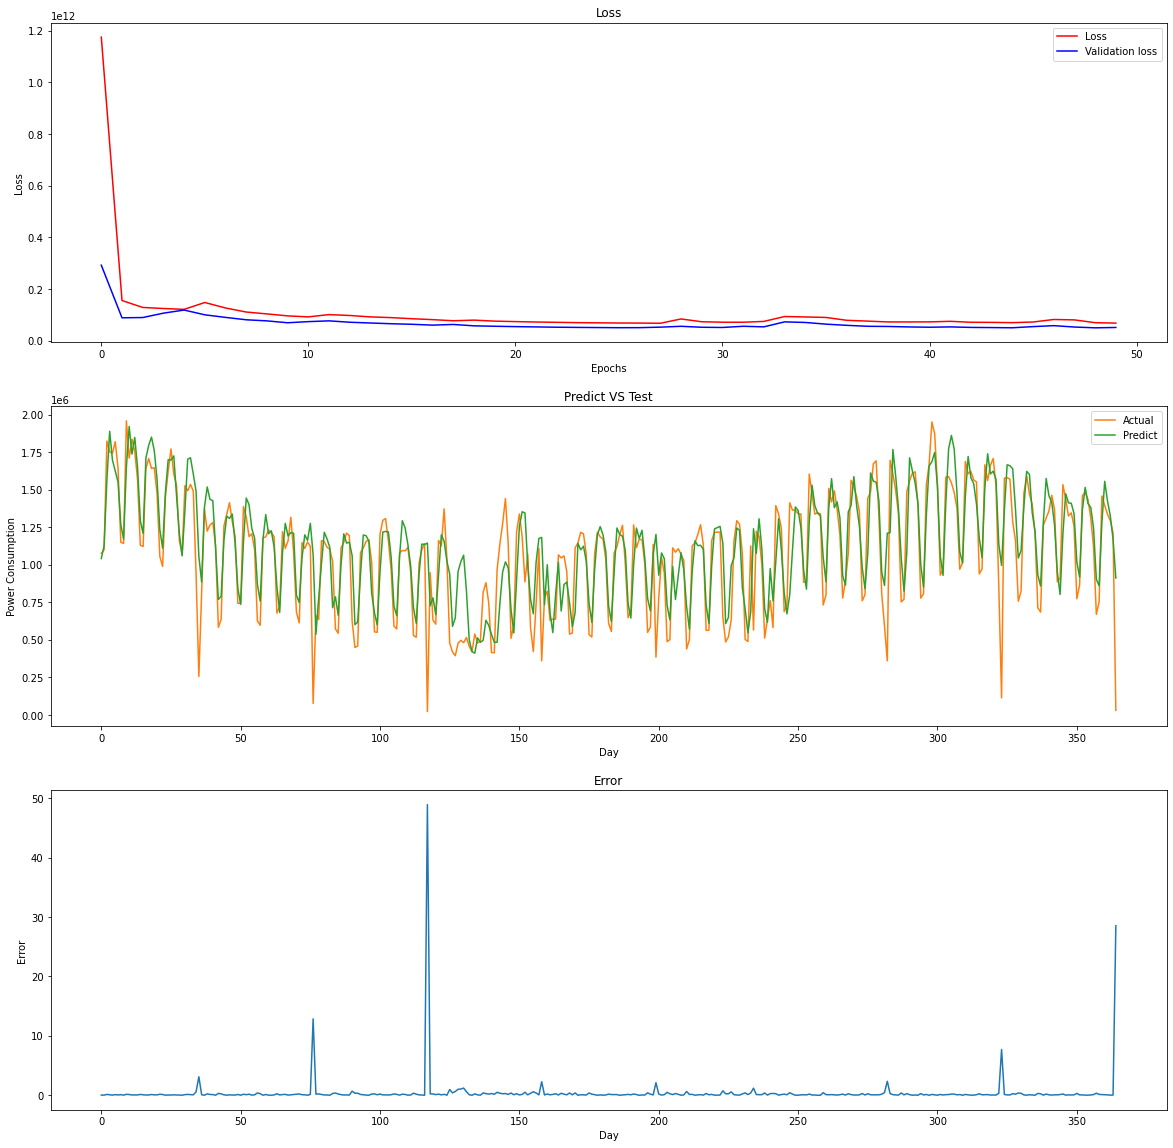

In [32]:
epochs=50
LSTM_layer_depth=100
y_p_epi3,y_test3,error3,y_pnew3=model_main_repeat(episodes,data_,model_choice=2)

dataset2

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9

Short term forecasting
MAPE STF 0.0857317659909008
MAE STF 140143.44098571438
RMSE STF 180501.0433692264

Medium term forcasting
MAPE MTF 0.06783749159586104
MAE MTF 101699.21085799999
RMSE MTF 139591.9091053572

Long term forecasting
MAPE LTF 0.35641780847562543
MAE LTF 151772.8629038356
RMSE LTF 217303.10200753398


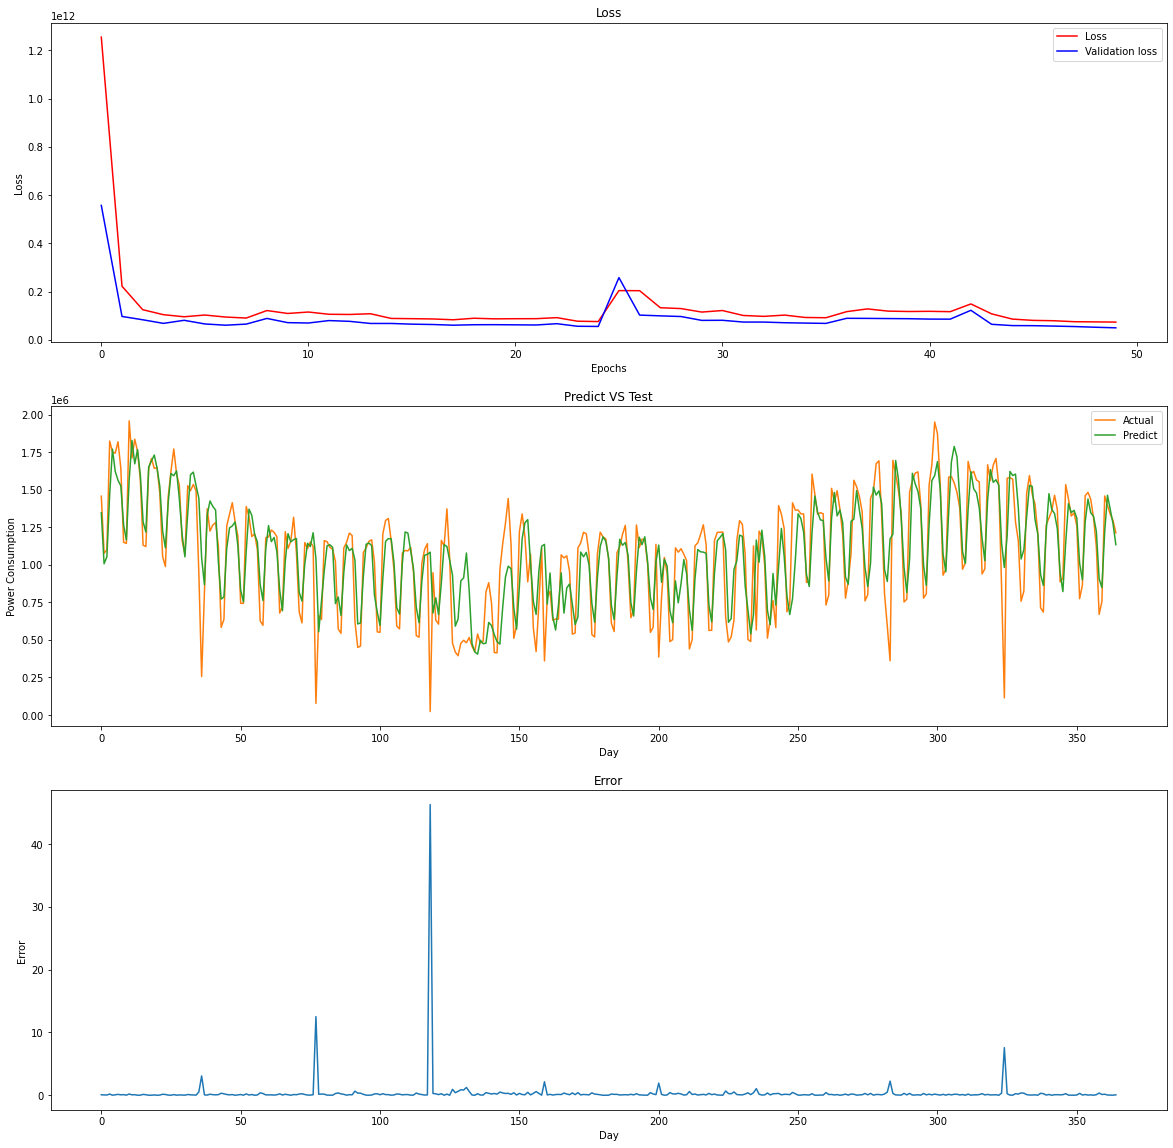

In [33]:
epochs=50
LSTM_layer_depth=100

y_p_epi33,y_test33,error33,y_pnew33=model_main_repeat(episodes,data_new,model_choice=2)

Vanilla LSTM - Multivariate

dataset1

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9

Short term forecasting
MAPE STF 0.07780754203569318
MAE STF 124776.26217428561
RMSE STF 152742.32171971267

Medium term forcasting
MAPE MTF 0.08600686563402414
MAE MTF 116575.15916799995
RMSE MTF 146304.23680580512

Long term forecasting
MAPE LTF 0.4628829309453462
MAE LTF 168347.11641260274
RMSE LTF 235095.18860146948


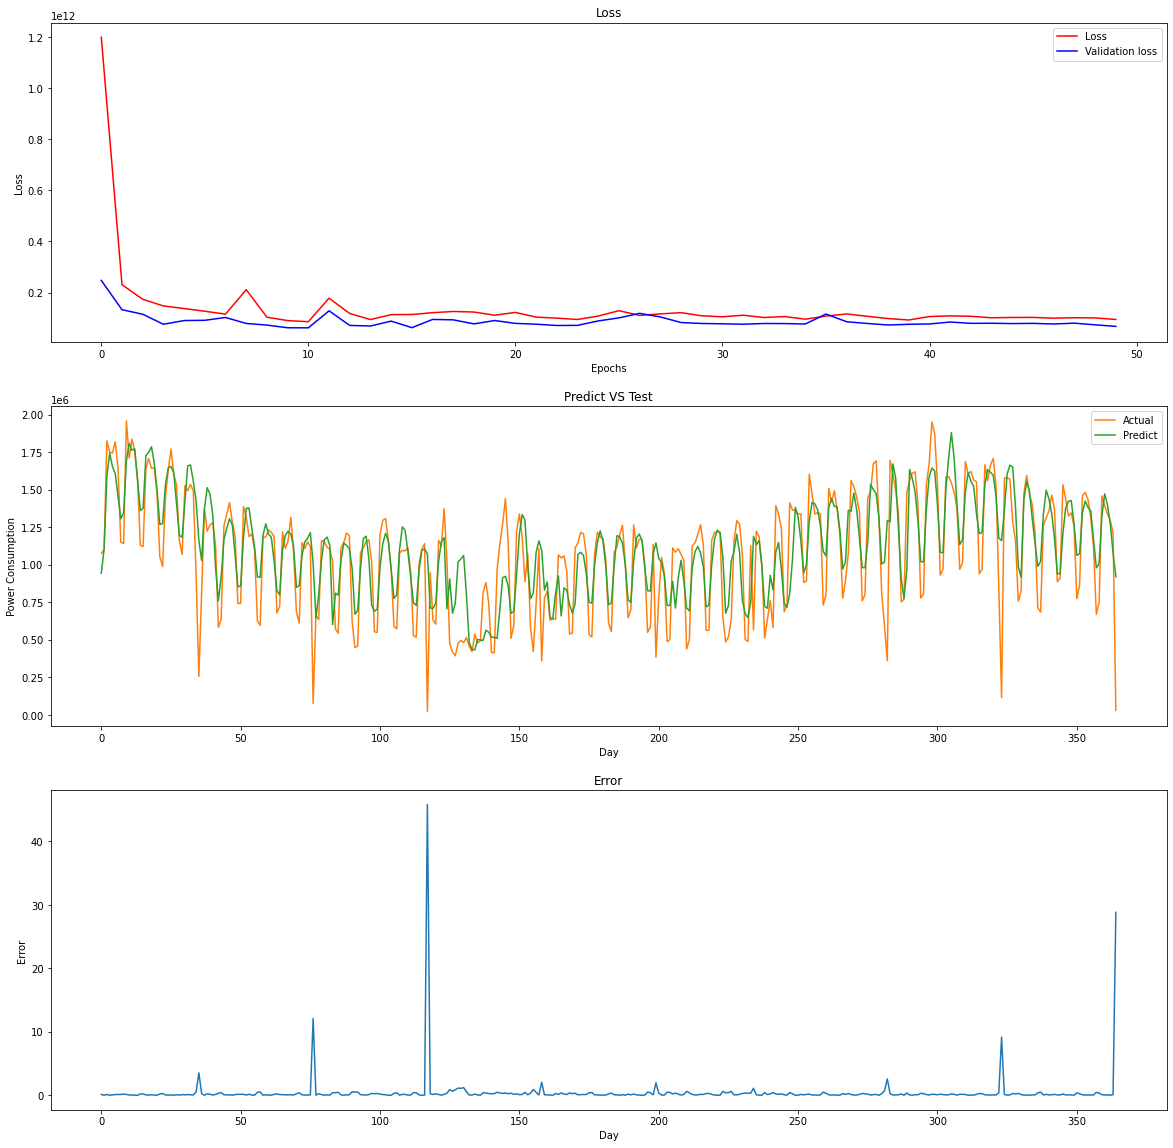

In [34]:
epochs=50
LSTM_layer_depth=100

y_p_epi4,y_test4,error4,y_pnew4=model_main_repeat(episodes,data_,model_choice=6)

dataset2

Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9

Short term forecasting
MAPE STF 0.09115307663670544
MAE STF 136942.6350685715
RMSE STF 160985.32629340937

Medium term forcasting
MAPE MTF 0.08609090022216716
MAE MTF 121583.72887533334
RMSE MTF 145242.26190912808

Long term forecasting
MAPE LTF 0.3776467232510859
MAE LTF 159261.85885219177
RMSE LTF 227035.05594468123


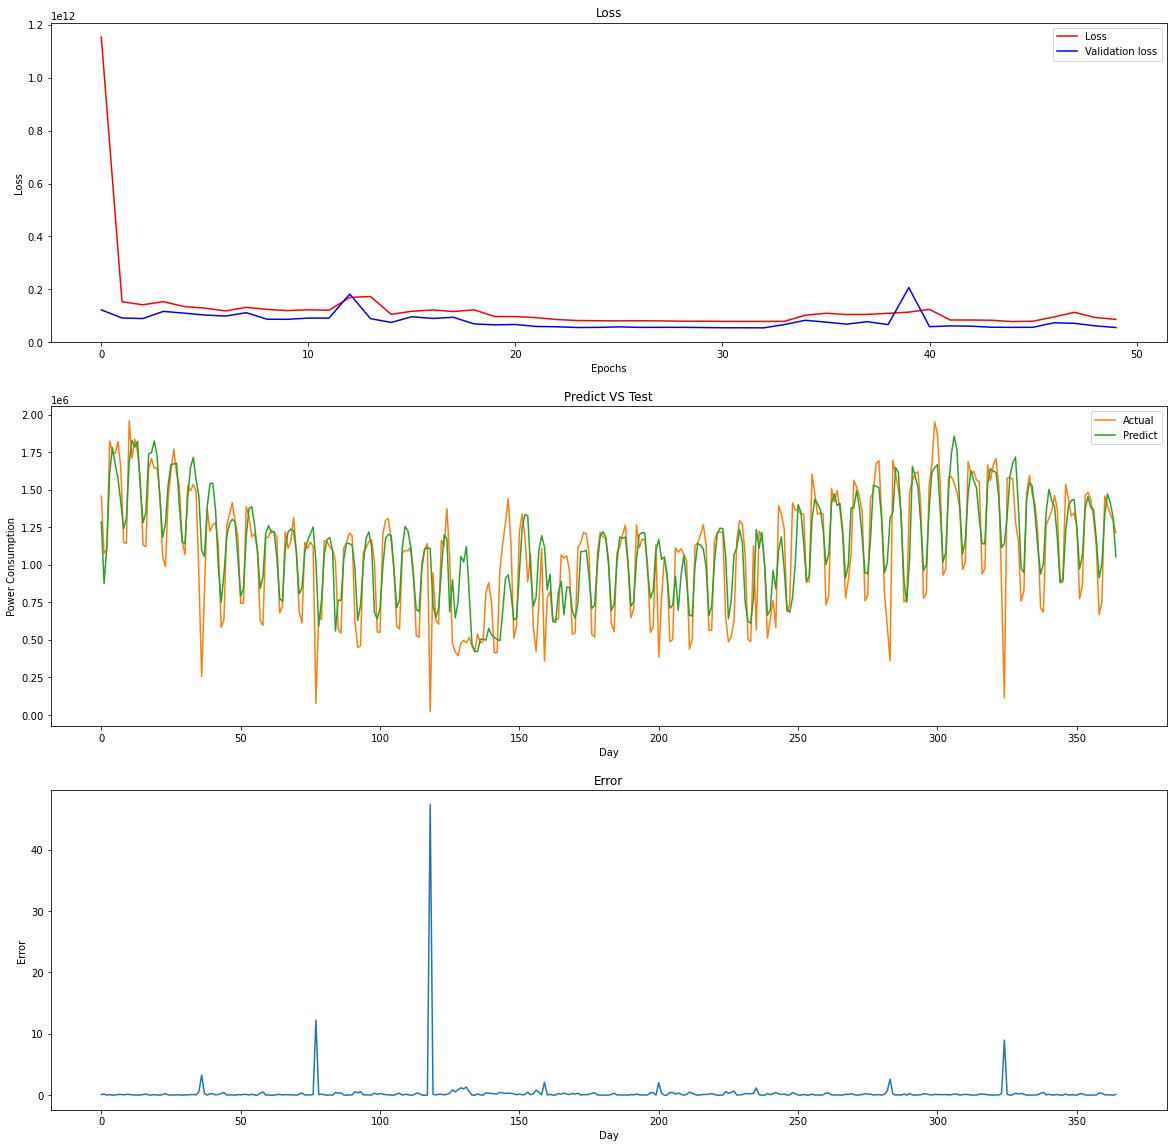

In [35]:
epochs=50
LSTM_layer_depth=100

y_p_epi44,y_test44,error44,y_pnew44=model_main_repeat(episodes,data_new,model_choice=6)

Tried to include mpre layers, depth. Results did not improve as expected.

In [24]:
# def model1_ADD(LSTM_layer_depth,lag,validation,data_,batch_size,epochs):
    
#     x,y=create_lag_m(data_,lag)
#     x_train,y_train,x_test,y_test=create_split(x,y,days)
    
    
#     verbose=0
#     model=Sequential()
#     model.add(LSTM(LSTM_layer_depth,return_sequences=True, activation='relu', input_shape=(lag, 2))) #change for features
#     model.add(LSTM(LSTM_layer_depth, return_sequences=False))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')

#     keras_dict = {
#         'x': x_train,
#         'y': y_train,
#         'batch_size': batch_size,
#         'epochs': epochs,
#         'shuffle': False,
#         'verbose':0
#     }

#     if validation==True:
#         keras_dict.update({
#             'validation_data': (x_test, y_test)
#         })

#     history=model.fit(
#         **keras_dict
#     )
    
#     #Predict using walk fwd validation 
#     y_p=model.predict(x_test) 

        
#     model=model

#     return model,history,y_p,y_test


# def model5(LSTM_layer_depth,lag,validation,data,batch_size,epochs):
#     #LSTM_layer_depth,lag,validation,data_new,batch_size,epochs
#     #print("GRU, Added layer")

    
#     x,y=create_lag_m(data,lag)
#     x_train,y_train,x_test,y_test=create_split(x,y,days)
    
#     model=Sequential()
#     model.add(GRU(LSTM_layer_depth,  return_sequences=True,activation='relu' , input_shape=(lag, 2)))#cahnge for features
#     model.add(GRU(LSTM_layer_depth, return_sequences=False))
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')

#     keras_dict = {
#         'x': x_train,
#         'y': y_train,
#         'batch_size': batch_size,
#         'epochs': epochs,
#         "verbose":0,
#         'shuffle': False
#     }

#     if validation==True:
#         keras_dict.update({
#             'validation_data': (x_test, y_test)
#         })

#     history=model.fit(
#         **keras_dict
#     )
    
#     y_p=model.predict(x_test) 
#     model=model

#     return model,history,y_p,y_test

# def model8(LSTM_layer_depth,lag,validation,data_new,batch_size,epochs):
#     #LSTM_layer_depth=50
#     x,y=create_lag_m(data_new,lag)
#     x_train,y_train,x_test,y_test=create_split(x,y,days)
    
#     model=Sequential()
#     model.add(GRU(LSTM_layer_depth,return_sequences=True, activation='relu' , input_shape=(lag, 2)))#cahnge for features
#     model.add(GRU(100, return_sequences=False))
# #     model.add(LSTM(LSTM_layer_depth, activation='relu')) ,return_sequences=True
#     model.add(Dense(1))
#     model.compile(optimizer='adam', loss='mse')

#     keras_dict = {
#         'x': x_train,
#         'y': y_train,
#         'batch_size': batch_size,
#         'epochs': epochs,
#         "verbose":0,
#         'shuffle': False
#     }

#     if validation==True:
#         keras_dict.update({
#             'validation_data': (x_test, y_test)
#         })

#     history=model.fit(
#         **keras_dict
#     )
    
#     y_p=model.predict(x_test) 

#     model=model

#     return model,history,y_p,y_test